## Neural Net from video with 128px, data scaled with MinMaxScaler, No test_train_split is used

In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [53]:
# Inlezen van CSV-bestand
dataPositions = pd.read_csv('../data-train-sin/positions_xyz_128px_2024-03-05_full.csv')
dataCoordinates = pd.read_csv('../data-train-sin/red_ball_coordinates_128px_2024-03-05_full.csv')
dataPositions.shape, dataCoordinates.shape

((10543, 3), (10543, 14))

In [54]:
combined = pd.concat([dataCoordinates, dataPositions], axis=1)
# remove the rows with to more than 3 NaN values
combined = combined.dropna()
combined = combined

In [55]:
X = combined.iloc[:, :14] # select all rows and columns from 0 to 13
y = combined.iloc[:, 14:] # select x y z output columns

### Data Preprocessing

### Splitting the dataset into the Training set and Test set

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

### Hyperparameter tuning

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor

# Define a parameter grid for the MLPRegressor
param_grid = {
    'model__hidden_layer_sizes': [(100,), (150,), (200,)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [10000, 20000, 28000],
    'model__early_stopping': [True],
}

# Create a pipeline with an MLPRegressor model
pipeline = Pipeline([
    ('model', MLPRegressor(random_state=42))
])
model = MLPRegressor(hidden_layer_sizes=(200,), solver='adam', max_iter=10000, early_stopping=True, random_state=42, activation='logistic', learning_rate='constant', learning_rate_init=0.1)
# Perform a randomized search over the parameter grid
#{'model__solver': 'adam', 'model__max_iter': 10000, 'model__learning_rate_init': 0.01, 'model__learning_rate': 'constant', 'model__hidden_layer_sizes': (200,), 'model__early_stopping': True, 'model__activation': 'logistic'}
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

#### Train the model

In [58]:
model.fit(X_scaled, y_scaled)

MLPRegressor(activation='logistic', early_stopping=True,
             hidden_layer_sizes=(200,), learning_rate_init=0.1, max_iter=10000,
             random_state=42)

#### Result of the hyperparameter tuning

In [59]:
#model = random_search.best_estimator_

In [60]:
#print('fBest parameters found:\n', random_search.best_params_)

# Make Predictions on new data

In [61]:
test_data = pd.read_csv('../data-test-sin/red_ball_coordinates_2024-03-05_12h01m.csv', delimiter=',', decimal='.')
test_result = pd.read_csv('../data-test-sin/positions_xyz_2024-03-05_12h01m.csv', delimiter=',', decimal='.')

In [62]:
new_combined = pd.concat([test_data, test_result], axis=1)
new_combined = new_combined.dropna()
new_combined = new_combined

In [63]:
new_X = new_combined.iloc[:, :14]
new_y = new_combined.iloc[:, 14:]
new_X.shape, new_y.shape

((1358, 14), (1358, 3))

In [64]:
new_X_scaled = scaler_X.fit_transform(new_X)
new_y_scaled = scaler_y.fit_transform(new_y)

In [65]:
new_y_pred_scaled = model.predict(new_X_scaled)

In [66]:
new_y_pred = scaler_y.inverse_transform(new_y_pred_scaled)

In [67]:
from utils.evaluate import evaluate_model

new_mse, new_mae, new_r2 = evaluate_model(new_y, new_y_pred, "New Data")

Mean Squared Error on New Data Set: 3.8747799805043397
Mean Absolute Error on New Data Set: 1.4987687105712588
R2 Score on New Data set: 0.10790007750182314


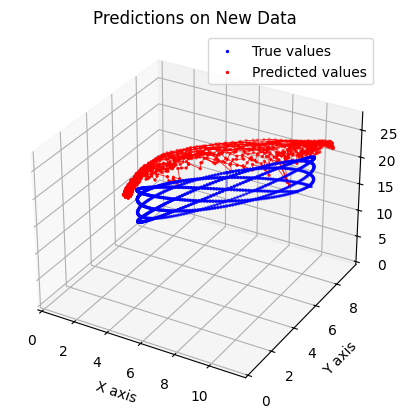

In [68]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(np.array(new_y), np.array(new_y_pred), "Predictions on New Data")